In [1]:
import os
import numpy as np
import pandas as pd
from joblib import dump, load
import sys
import seaborn as sns
import json
sys.path.append(os.path.join(os.path.abspath('../'), 'predictions_collapsed'))
sys.path.append(os.path.join(os.path.abspath('../'), 'src'))
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import torch
import skorch
import glob


from config_loader import (
    D_CONFIG,
    DATASET_SITE_PATH, DATASET_SPLIT_PATH,
    DATASET_FEAT_PER_TSLICE_PATH,
    PROJECT_REPO_DIR, PROJECT_CONDA_ENV_YAML,
    RESULTS_SPLIT_PATH, RESULTS_FEAT_PER_TSTEP_PATH)

# sys.path.append(os.path.join(PROJECT_REPO_DIR, 'src'))
# sys.path.append(os.path.join(PROJECT_REPO_DIR, 'src', 'rnn'))
# from feature_transformation import *
# from filter_admissions_by_tslice import get_preprocessed_data
# from merge_features_all_tslices import merge_data_dicts, get_all_features_data
# import matplotlib.pyplot as plt
# from sklearn.metrics import (accuracy_score, balanced_accuracy_score, f1_score,
#                              average_precision_score, confusion_matrix, log_loss,
#                              roc_auc_score, roc_curve, precision_recall_curve)
# from utils import load_data_dict_json
# from dataset_loader import TidySequentialDataCSVLoader
# from RNNBinaryClassifier import RNNBinaryClassifier
# from sklearn.model_selection import GridSearchCV
RESULTS_FEAT_PER_TSTEP_PATH = os.path.join(RESULTS_FEAT_PER_TSTEP_PATH, 'rnn')
CLF_TRAIN_TEST_SPLIT_PATH=os.path.join(DATASET_FEAT_PER_TSLICE_PATH, 'classifier_train_test_split')

In [2]:
RESULTS_FEAT_PER_TSTEP_PATH

'/tmp/results/madrid/v20210119/HHE/split-by=patient_id/features_per_timestep/rnn'

## Plot loss curves

## RNN losses

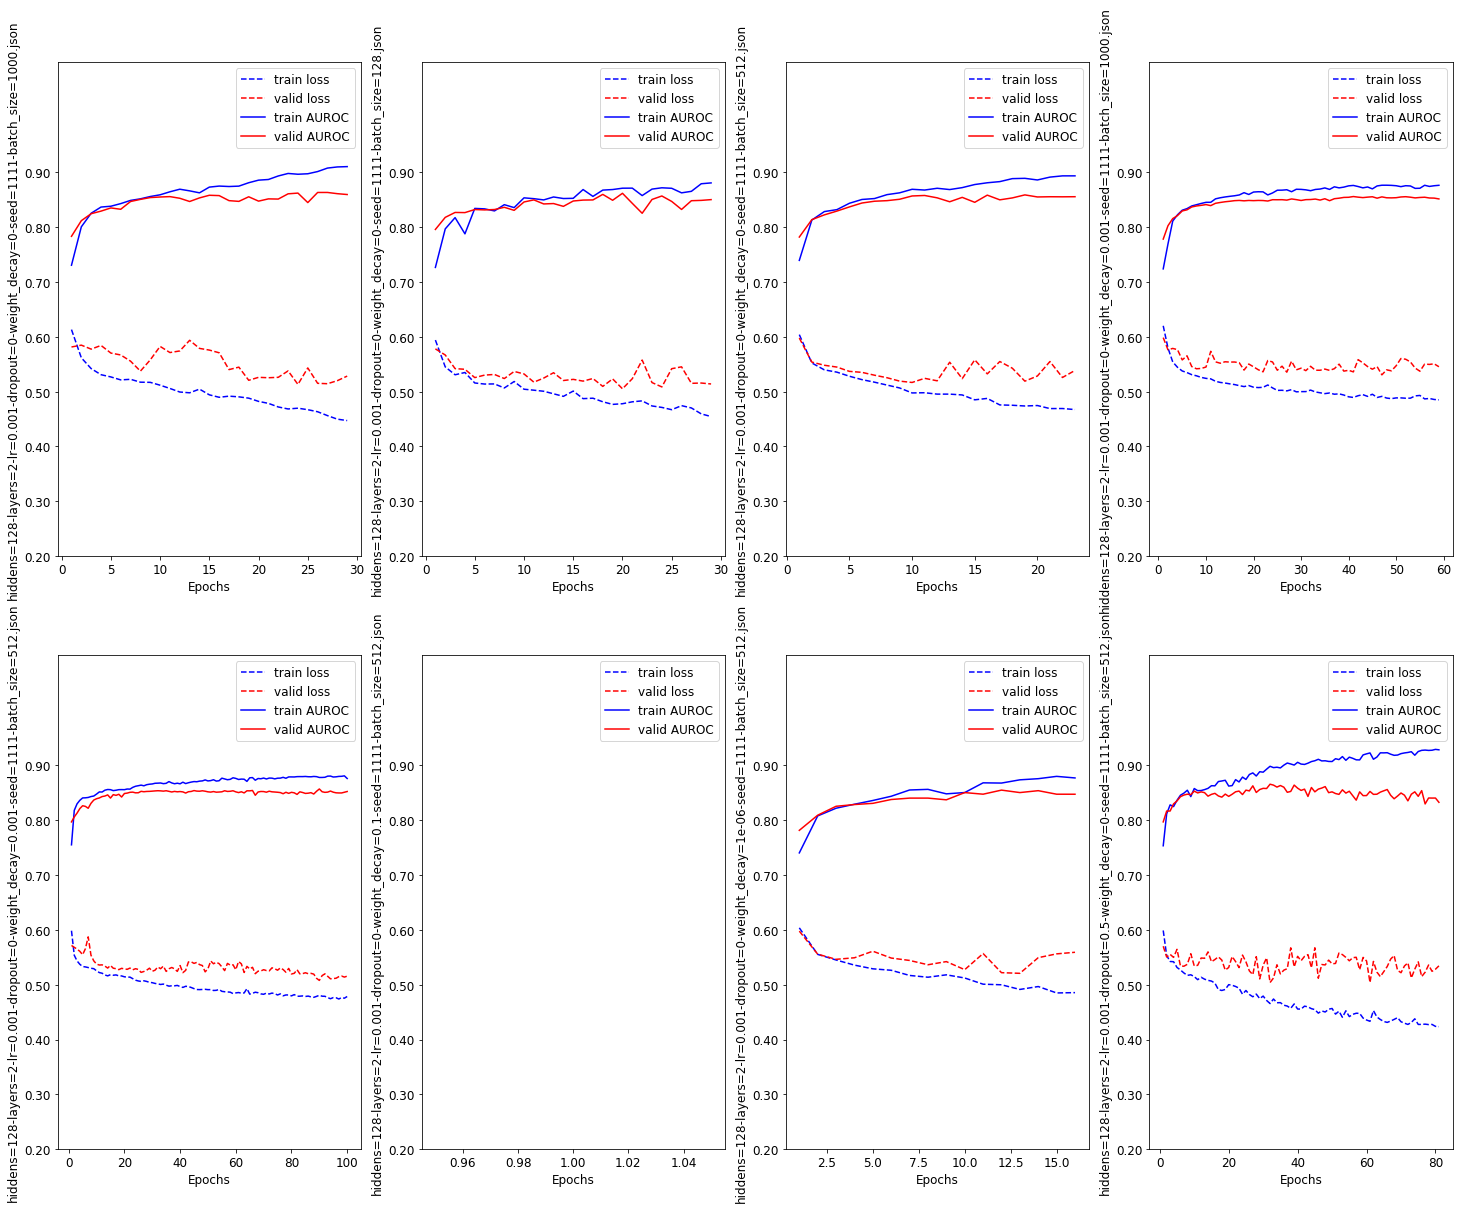

In [8]:
f, axs= plt.subplots(2,4, figsize=(25,20))

ticks = np.arange(0, 1, 0.1)
ticklabels = ['%.2f'%i for i in ticks]
axs_list = axs.flatten()
rnn_hists_json = glob.glob(os.path.join(RESULTS_FEAT_PER_TSTEP_PATH, '*hiddens=128*lr=0.001*batch_size=*.json'))
rnn_hists_json = [i for i in rnn_hists_json if 'history' not in i]
rnn_hists_json.sort()

for i, rnn_hist_json in enumerate(rnn_hists_json):
    with open(rnn_hist_json, 'r') as g:
        rnn_dict = json.load(g)
    epochs=[i['epoch'] for i in rnn_dict[:-1]]
    train_loss = [i['train_loss'] for i in rnn_dict[:-1]]
    valid_loss = [i['valid_loss'] for i in rnn_dict[:-1]]
    aucroc_score_train = [i['aucroc_score_train'] for i in rnn_dict[:-1]]
    aucroc_score_valid = [i['aucroc_score_valid'] for i in rnn_dict[:-1]]

#     f, axs = plt.subplots(2,1,figsize=(12,10), sharex=True)
    plt.rcParams.update({'font.size': 12})
    axs_list[i].plot(epochs, train_loss, 'b--', label='train loss')
    axs_list[i].plot(epochs, valid_loss, 'r--', label='valid loss')
    axs_list[i].set_xlabel('Epochs')
#     axs_list[i].set_ylabel('Loss')
    axs_list[i].plot(epochs, aucroc_score_train, 'b', label='train AUROC')
    axs_list[i].plot(epochs, aucroc_score_valid, 'r', label='valid AUROC')
    axs_list[i].set_xlabel('Epochs')
    axs_list[i].legend()
    axs_list[i].set_ylabel(rnn_hist_json.split('/')[-1])
    axs_list[i].set_yticks(ticks)
    axs_list[i].set_yticklabels(ticklabels)
    axs_list[i].set_ylim([0.2, 1.1])

# f.savefig('loss_plots_lr=0.001.png')
# plt.suptitle('Hidden units=64, Hidden layers=2, Weight decay=1e-6, dropout=0.3,Optimizer=Adam, clipping=0.01')
plt.show()



In [6]:
rnn_hists_json = glob.glob(os.path.join(RESULTS_FEAT_PER_TSTEP_PATH, '*hiddens=128*lr=0.001*batch_size=*.json'))
rnn_hists_json = [i for i in rnn_hists_json if 'history' not in i]
rnn_hists_json

['/tmp/results/madrid/v20200424/HUF/split-by=patient_id/features_per_timestep/rnn/hiddens=128-layers=2-lr=0.001-dropout=0-weight_decay=0-seed=1111-batch_size=128.json',
 '/tmp/results/madrid/v20200424/HUF/split-by=patient_id/features_per_timestep/rnn/hiddens=128-layers=2-lr=0.001-dropout=0-weight_decay=0-seed=1111-batch_size=1000.json',
 '/tmp/results/madrid/v20200424/HUF/split-by=patient_id/features_per_timestep/rnn/hiddens=128-layers=2-lr=0.001-dropout=0-weight_decay=0-seed=1111-batch_size=512.json']

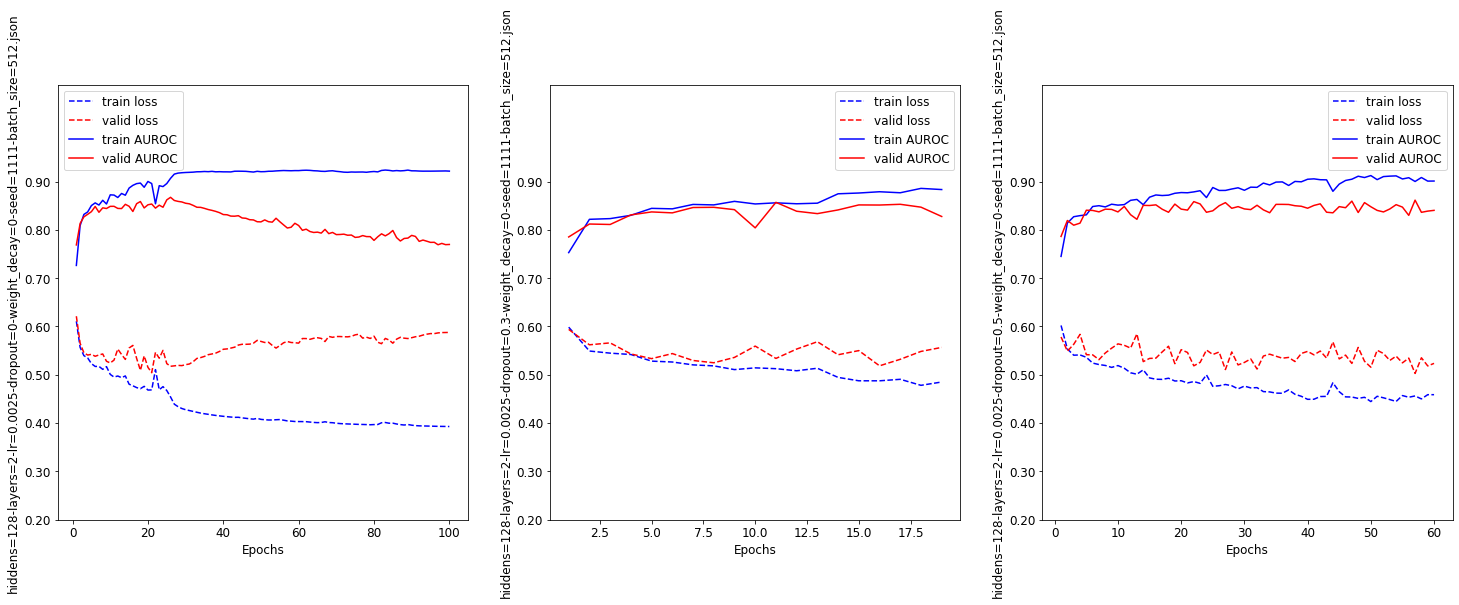

In [9]:
f, axs= plt.subplots(1,3, figsize=(25,8))

ticks = np.arange(0, 1, 0.1)
ticklabels = ['%.2f'%i for i in ticks]
axs_list = axs.flatten()
rnn_hists_json = glob.glob(os.path.join(RESULTS_FEAT_PER_TSTEP_PATH, '*hiddens=128*lr=0.0025*batch_size=*.json'))
rnn_hists_json = [i for i in rnn_hists_json if 'history' not in i]
rnn_hists_json.sort()

for i, rnn_hist_json in enumerate(rnn_hists_json):
    with open(rnn_hist_json, 'r') as g:
        rnn_dict = json.load(g)
    epochs=[i['epoch'] for i in rnn_dict[:-1]]
    train_loss = [i['train_loss'] for i in rnn_dict[:-1]]
    valid_loss = [i['valid_loss'] for i in rnn_dict[:-1]]
    aucroc_score_train = [i['aucroc_score_train'] for i in rnn_dict[:-1]]
    aucroc_score_valid = [i['aucroc_score_valid'] for i in rnn_dict[:-1]]

#     f, axs = plt.subplots(2,1,figsize=(12,10), sharex=True)
    plt.rcParams.update({'font.size': 12})
    axs_list[i].plot(epochs, train_loss, 'b--', label='train loss')
    axs_list[i].plot(epochs, valid_loss, 'r--', label='valid loss')
    axs_list[i].set_xlabel('Epochs')
#     axs_list[i].set_ylabel('Loss')
    axs_list[i].plot(epochs, aucroc_score_train, 'b', label='train AUROC')
    axs_list[i].plot(epochs, aucroc_score_valid, 'r', label='valid AUROC')
    axs_list[i].set_xlabel('Epochs')
    axs_list[i].legend()
    axs_list[i].set_ylabel(rnn_hist_json.split('/')[-1])
    axs_list[i].set_yticks(ticks)
    axs_list[i].set_yticklabels(ticklabels)
    axs_list[i].set_ylim([0.2, 1.1])

f.savefig('loss_plots_lr=0.0025.png')
# plt.suptitle('Hidden units=64, Hidden layers=2, Weight decay=1e-6, dropout=0.3,Optimizer=Adam, clipping=0.01')
plt.show()



## Smaller models

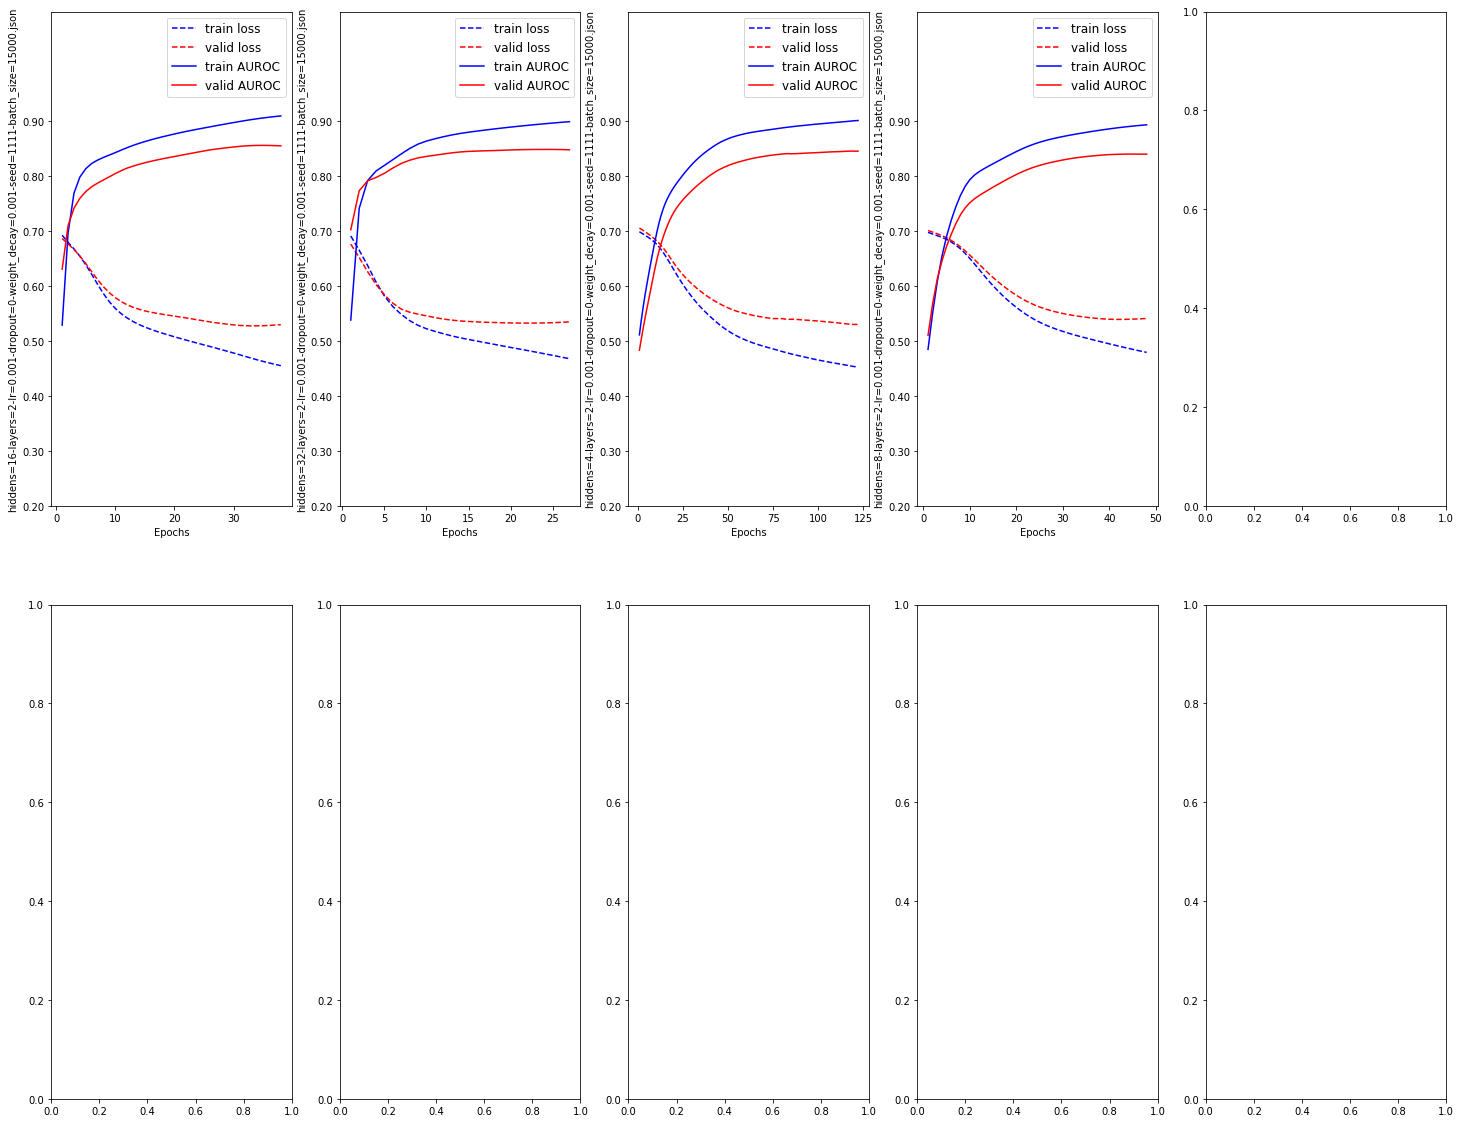

In [2]:
f, axs= plt.subplots(2,5, figsize=(25,20))

ticks = np.arange(0, 1, 0.1)
ticklabels = ['%.2f'%i for i in ticks]
axs_list = axs.flatten()
rnn_hists_json = glob.glob(os.path.join(RESULTS_FEAT_PER_TSTEP_PATH, '*hiddens=*lr=0.001*batch_size=15000.json'))
rnn_hists_json = [i for i in rnn_hists_json if 'history' not in i]
rnn_hists_json.sort()


auroc_list = []
model_list = []
for i, rnn_hist_json in enumerate(rnn_hists_json):
    with open(rnn_hist_json, 'r') as g:
        rnn_dict = json.load(g)
    epochs=[i['epoch'] for i in rnn_dict[:-1]]
    train_loss = [i['train_loss'] for i in rnn_dict[:-1]]
    valid_loss = [i['valid_loss'] for i in rnn_dict[:-1]]
    aucroc_score_train = [i['aucroc_score_train'] for i in rnn_dict[:-1]]
    aucroc_score_valid = [i['aucroc_score_valid'] for i in rnn_dict[:-1]]
    auroc_list.append(aucroc_score_valid[-1])
    model_list.append(rnn_hist_json)

#     f, axs = plt.subplots(2,1,figsize=(12,10), sharex=True)
    plt.rcParams.update({'font.size': 12})
    axs_list[i].plot(epochs, train_loss, 'b--', label='train loss')
    axs_list[i].plot(epochs, valid_loss, 'r--', label='valid loss')
    axs_list[i].set_xlabel('Epochs')
#     axs_list[i].set_ylabel('Loss')
    axs_list[i].plot(epochs, aucroc_score_train, 'b', label='train AUROC')
    axs_list[i].plot(epochs, aucroc_score_valid, 'r', label='valid AUROC')
    axs_list[i].set_xlabel('Epochs')
    axs_list[i].legend()
    axs_list[i].set_ylabel(rnn_hist_json.split('/')[-1])
    axs_list[i].set_yticks(ticks)
    axs_list[i].set_yticklabels(ticklabels)
    axs_list[i].set_ylim([0.2, 1.1])

# f.savefig('loss_plots_lr=0.001.png')
# plt.suptitle('Hidden units=64, Hidden layers=2, Weight decay=1e-6, dropout=0.3,Optimizer=Adam, clipping=0.01')
plt.show()



In [5]:
model_list[np.argmax(auroc_list)]

model_list

['/tmp/results/madrid/v20210119/HUF/split-by=patient_id/features_per_timestep/rnn/hiddens=16-layers=2-lr=0.001-dropout=0-weight_decay=0.001-seed=1111-batch_size=15000.json',
 '/tmp/results/madrid/v20210119/HUF/split-by=patient_id/features_per_timestep/rnn/hiddens=32-layers=2-lr=0.001-dropout=0-weight_decay=0.001-seed=1111-batch_size=15000.json',
 '/tmp/results/madrid/v20210119/HUF/split-by=patient_id/features_per_timestep/rnn/hiddens=4-layers=2-lr=0.001-dropout=0-weight_decay=0.001-seed=1111-batch_size=15000.json',
 '/tmp/results/madrid/v20210119/HUF/split-by=patient_id/features_per_timestep/rnn/hiddens=8-layers=2-lr=0.001-dropout=0-weight_decay=0.001-seed=1111-batch_size=15000.json']

## HHE

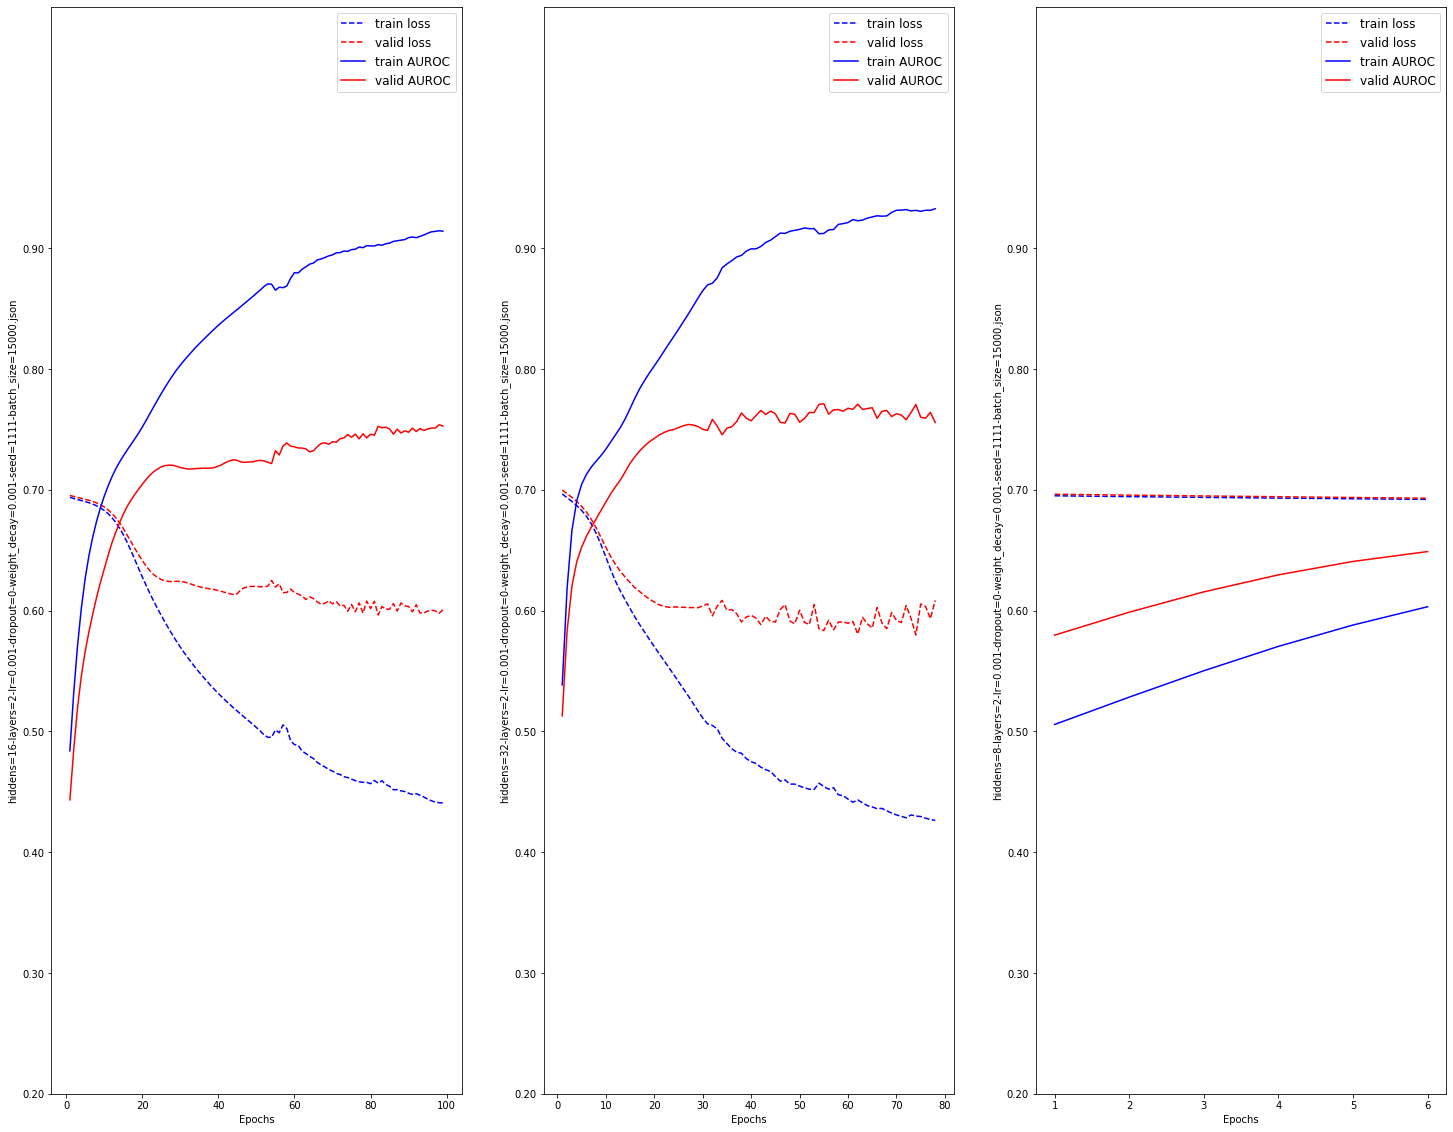

In [3]:
f, axs= plt.subplots(1,3, figsize=(25,20))

ticks = np.arange(0, 1, 0.1)
ticklabels = ['%.2f'%i for i in ticks]
axs_list = axs.flatten()
rnn_hists_json = glob.glob(os.path.join(RESULTS_FEAT_PER_TSTEP_PATH, '*hiddens=*lr=0.001*batch_size=15000.json'))
rnn_hists_json = [i for i in rnn_hists_json if 'history' not in i]
rnn_hists_json.sort()


auroc_list = []
model_list = []
for i, rnn_hist_json in enumerate(rnn_hists_json):
    with open(rnn_hist_json, 'r') as g:
        rnn_dict = json.load(g)
    epochs=[i['epoch'] for i in rnn_dict[:-1]]
    train_loss = [i['train_loss'] for i in rnn_dict[:-1]]
    valid_loss = [i['valid_loss'] for i in rnn_dict[:-1]]
    aucroc_score_train = [i['aucroc_score_train'] for i in rnn_dict[:-1]]
    aucroc_score_valid = [i['aucroc_score_valid'] for i in rnn_dict[:-1]]
    auroc_list.append(aucroc_score_valid[-1])
    model_list.append(rnn_hist_json)

#     f, axs = plt.subplots(2,1,figsize=(12,10), sharex=True)
    plt.rcParams.update({'font.size': 12})
    axs_list[i].plot(epochs, train_loss, 'b--', label='train loss')
    axs_list[i].plot(epochs, valid_loss, 'r--', label='valid loss')
    axs_list[i].set_xlabel('Epochs')
#     axs_list[i].set_ylabel('Loss')
    axs_list[i].plot(epochs, aucroc_score_train, 'b', label='train AUROC')
    axs_list[i].plot(epochs, aucroc_score_valid, 'r', label='valid AUROC')
    axs_list[i].set_xlabel('Epochs')
    axs_list[i].legend()
    axs_list[i].set_ylabel(rnn_hist_json.split('/')[-1])
    axs_list[i].set_yticks(ticks)
    axs_list[i].set_yticklabels(ticklabels)
    axs_list[i].set_ylim([0.2, 1.1])

# f.savefig('loss_plots_lr=0.001.png')
# plt.suptitle('Hidden units=64, Hidden layers=2, Weight decay=1e-6, dropout=0.3,Optimizer=Adam, clipping=0.01')
plt.show()


In [6]:
model_list[np.argmax(auroc_list)]

auroc_list

[0.7527505077860528, 0.7556697551760743, 0.6488628100002507]

## 200 units

In [ ]:
rnn_hist_json = os.path.join(RESULTS_FEAT_PER_TSTEP_PATH, 
                         'hiddens=200-layers=2-lr=0.0001-dropout=0.1-weight_decay=1e-06-seed=1111.json')


with open(rnn_hist_json, 'r') as f:
    rnn_dict = json.load(f)
epochs=[i['epoch'] for i in rnn_dict[:-1]]
train_loss = [i['train_loss'] for i in rnn_dict[:-1]]
valid_loss = [i['valid_loss'] for i in rnn_dict[:-1]]
aucroc_score_train = [i['aucroc_score_train'] for i in rnn_dict[:-1]]
aucroc_score_valid = [i['aucroc_score_valid'] for i in rnn_dict[:-1]]

f, axs = plt.subplots(2,1,figsize=(12,10), sharex=True)
plt.rcParams.update({'font.size': 12})
axs[0].plot(epochs, train_loss, 'b', label='train')
axs[0].plot(epochs, valid_loss, 'r', label='valid')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[1].plot(epochs, aucroc_score_train, 'b')
axs[1].plot(epochs, aucroc_score_valid, 'r')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('AUROC')
axs[0].set_title('Hidden units=200, Hidden layers=2, Weight decay=1e-6, dropout=0.1, Learning Rate=0.0001, Optimizer=Adam')
plt.show()

# HIL

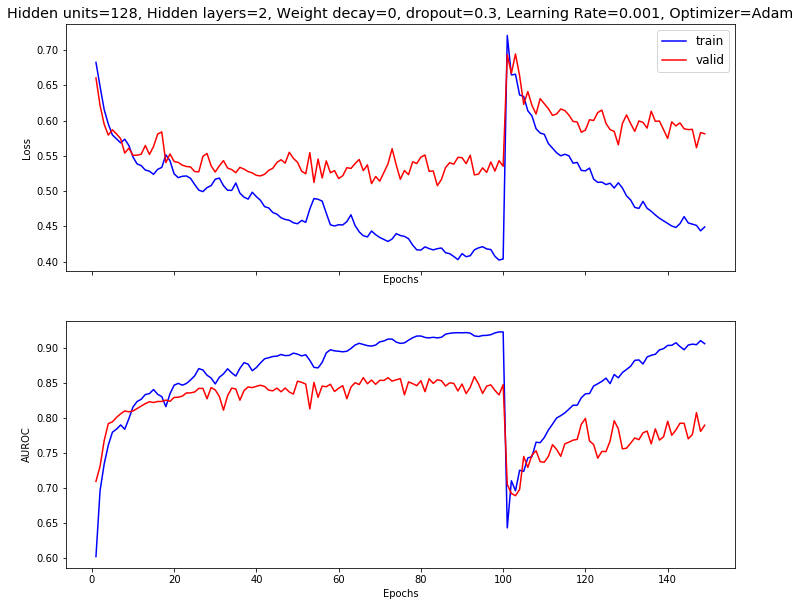

In [3]:
rnn_hist_json = os.path.join(RESULTS_FEAT_PER_TSTEP_PATH, 
                         'hiddens=128-layers=2-lr=0.001-dropout=0.3-weight_decay=0-seed=1111.json')


with open(rnn_hist_json, 'r') as f:
    rnn_dict = json.load(f)
epochs=[i['epoch'] for i in rnn_dict[:-1]]
train_loss = [i['train_loss'] for i in rnn_dict[:-1]]
valid_loss = [i['valid_loss'] for i in rnn_dict[:-1]]
aucroc_score_train = [i['aucroc_score_train'] for i in rnn_dict[:-1]]
aucroc_score_valid = [i['aucroc_score_valid'] for i in rnn_dict[:-1]]

f, axs = plt.subplots(2,1,figsize=(12,10), sharex=True)
plt.rcParams.update({'font.size': 12})
axs[0].plot(epochs, train_loss, 'b', label='train')
axs[0].plot(epochs, valid_loss, 'r', label='valid')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[1].plot(epochs, aucroc_score_train, 'b')
axs[1].plot(epochs, aucroc_score_valid, 'r')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('AUROC')
axs[0].set_title('Hidden units=128, Hidden layers=2, Weight decay=0, dropout=0.3, Learning Rate=0.001, Optimizer=Adam')
plt.show()

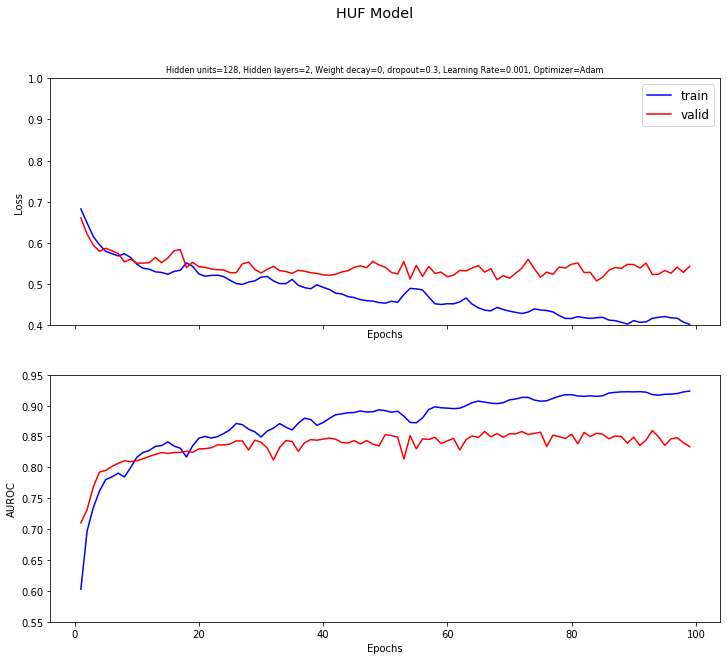

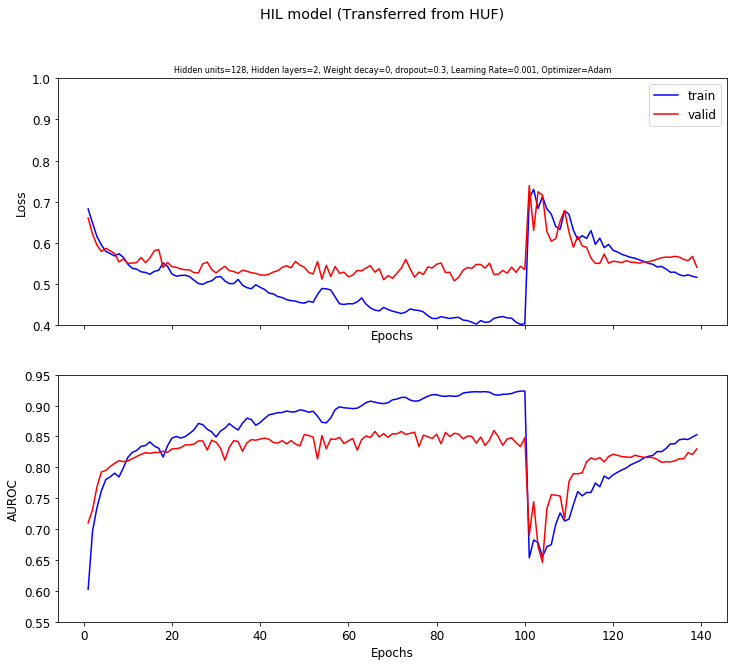

In [3]:
hil_model_dir = '/tmp/results/madrid/v20200424/HIL/split-by=patient_id/features_per_timestep/rnn/'
huf_model_dir = '/tmp/results/madrid/v20200424/HUF/split-by=patient_id/features_per_timestep/rnn/current_best_model'

model_dirs = [huf_model_dir, hil_model_dir]
model_names = ['HUF Model', 'HIL model (Transferred from HUF)']
for model_ind, model_dir in enumerate(model_dirs):
    rnn_hist_json = os.path.join(model_dir, 
                             'hiddens=128-layers=2-lr=0.001-dropout=0.3-weight_decay=0-seed=1111.json')


    with open(rnn_hist_json, 'r') as f:
        rnn_dict = json.load(f)
    epochs=[i['epoch'] for i in rnn_dict[:-1]]
    train_loss = [i['train_loss'] for i in rnn_dict[:-1]]
    valid_loss = [i['valid_loss'] for i in rnn_dict[:-1]]
    aucroc_score_train = [i['aucroc_score_train'] for i in rnn_dict[:-1]]
    aucroc_score_valid = [i['aucroc_score_valid'] for i in rnn_dict[:-1]]

    f, axs = plt.subplots(2,1,figsize=(12,10), sharex=True)
    plt.rcParams.update({'font.size': 12})
    axs[0].plot(epochs, train_loss, 'b', label='train')
    axs[0].plot(epochs, valid_loss, 'r', label='valid')
    axs[0].set_ylim([0.4, 1])
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[1].plot(epochs, aucroc_score_train, 'b')
    axs[1].plot(epochs, aucroc_score_valid, 'r')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('AUROC')
    axs[1].set_ylim([0.55, 0.95])
    axs[0].set_title('Hidden units=128, Hidden layers=2, Weight decay=0, dropout=0.3, Learning Rate=0.001, Optimizer=Adam',
                    fontsize=8)
    plt.suptitle(model_names[model_ind])
    f.savefig('%s loss plots'%model_names[model_ind])
    plt.show()


# Get per_tstep_performance csv's

In [14]:
per_tstep_dir = '/tmp/results/madrid/v20210419/HUF/split-by=patient_id/features_per_timestep/rnn_per_tstep'
per_tstep_csvs = glob.glob(os.path.join(per_tstep_dir, 'rnn_per_tstep*.csv'))
per_tstep_jsons = glob.glob(os.path.join(per_tstep_dir, 'rnn_per_tstep*.json'))

In [15]:
# 
precision_train_np = np.zeros(len(per_tstep_csvs))
recall_train_np = np.zeros(len(per_tstep_csvs))
precision_valid_np = np.zeros(len(per_tstep_csvs))
recall_valid_np = np.zeros(len(per_tstep_csvs))
precision_test_np = np.zeros(len(per_tstep_csvs))
recall_test_np = np.zeros(len(per_tstep_csvs))

for i, csv in enumerate(per_tstep_csvs):
    perf_df = pd.read_csv(csv)
    precision_train_np[i] = perf_df['precision_train']
    precision_valid_np[i] = perf_df['precision_valid']
    precision_test_np[i] = perf_df['precision_test']
    recall_train_np[i] = perf_df['recall_train']
    recall_valid_np[i] = perf_df['recall_valid']
    recall_test_np[i] = perf_df['recall_test']    

# perf_df

In [16]:
precision_train_np

array([0.46981627, 0.36609337, 0.43267108, 0.44343891, 0.46715328,
       0.32801822, 0.41176471, 0.45066667, 0.4569378 , 0.46717172,
       0.48584906, 0.42961165, 0.44010417, 0.47683924, 0.45605701,
       0.26306985, 0.35070575, 0.45      , 0.43646409, 0.38411317,
       0.44358974, 0.49457701, 0.41726619, 0.36978417, 0.42723005,
       0.33783784, 0.34669811, 0.4534005 , 0.45687646, 0.48051948,
       0.22916667, 0.41564792, 0.37292162, 0.45822785, 0.35365854,
       0.34475138, 0.38388626, 0.42234332, 0.34725051, 0.37476636,
       0.3800905 , 0.47429907, 0.33723404, 0.33429119, 0.42447917,
       0.44525547, 0.46153846, 0.34422111])

In [17]:
keep_inds = precision_train_np>=0.25
precs = precision_valid_np[keep_inds]
recs = recall_valid_np[keep_inds]
csvs = np.asarray(per_tstep_csvs)[keep_inds]
print(pd.read_csv(csvs[np.argmax(recs)]))
print(csvs[np.argmax(recs)])

   auroc_train  auroc_valid  auroc_test  precision_train  precision_valid  \
0      0.92471     0.879058     0.85628          0.26307         0.223183   

   precision_test  recall_train  recall_valid  recall_test  threshold  
0        0.198151      0.618486      0.509881     0.480769   0.726826  
/tmp/results/madrid/v20210419/HUF/split-by=patient_id/features_per_timestep/rnn_per_tstep/rnn_per_tstep_hiddens=16-layers=2-lr=0.005-dropout=0-weight_decay=1e-05-seed=1111-batch_size=5000.csv


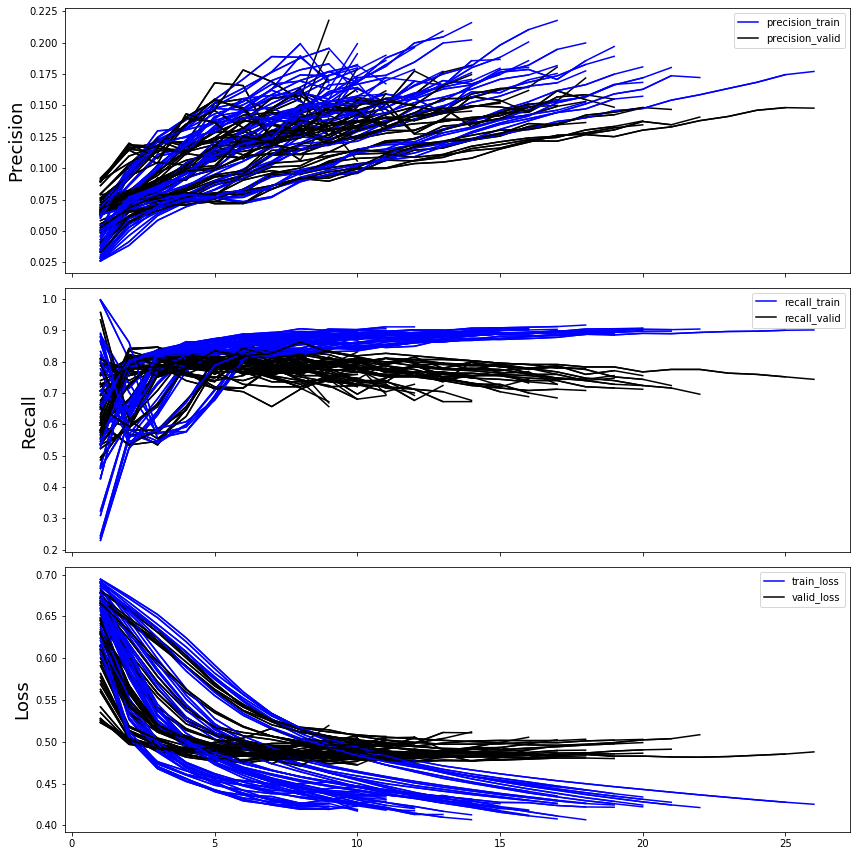

In [18]:
f, axs = plt.subplots(3, 1, figsize=(12,12), sharex=True)

fontsize=18
for ii, perf_json in enumerate(per_tstep_jsons):
    perf_df = pd.DataFrame(json.load(open(perf_json)))
    epochs = perf_df['epoch'].values
    precision_train = perf_df['precision_train'].values
    precision_valid = perf_df['precision_valid'].values
#     precision_test = perf_df['precision_test'].values
    recall_train = perf_df['recall_train'].values
    recall_valid = perf_df['recall_valid'].values
    
    loss_train = perf_df['train_loss'].values
    loss_valid = perf_df['valid_loss'].values
#     recall_test = perf_df['recall_test'].values    
    
    axs[0].plot(epochs, precision_train, label='precision_train', color='b')
    axs[0].plot(epochs, precision_valid, label='precision_valid', color='k')
    axs[0].set_ylabel('Precision', fontsize=fontsize)
    
    axs[1].plot(epochs, recall_train, label='recall_train',  color='b')
    axs[1].plot(epochs, recall_valid, label='recall_valid', color='k')
    axs[1].set_ylabel('Recall', fontsize=fontsize)
    
    axs[2].plot(epochs, loss_train, label='train_loss',  color='b')
    axs[2].plot(epochs, loss_valid, label='valid_loss', color='k')
    axs[2].set_ylabel('Loss', fontsize=fontsize)
    
    if ii==0:
        axs[0].legend()
        axs[1].legend()
        axs[2].legend()
    
#     plt.suptitle('Training Plots Across Hyperparameters')
    
#     axs[2].plot(epochs, precision_test, label='precision_test')
#     axs[2].plot(epochs, recall_test, label='recall_test')


plt.tight_layout()
f.savefig('HUF_RNN_training_plots.png')
plt.show()